In [108]:
gpu_id = 7
import data_handler
import dilated_model as DM
import trainer as T
import numpy as np
import torch as th
from torch.autograd import Variable
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
from os.path import basename, splitext

th.multiprocessing.set_sharing_strategy('file_system')
name = splitext(basename(sys.argv[0]))[0]

transformations = [
    data_handler.Crop(600),
    data_handler.Threshold(sigma=2.2),
    data_handler.RandomMultiplier(-1),
]

dataset = data_handler.DataSet(
    'data/raw/training2017/REFERENCE.csv', data_handler.load_composed,
    transformations=transformations,
    path='data/raw/training2017/',
    remove_noise=True, tokens='NAO')
train_set, eval_set = dataset.disjunct_split(.9)


scratch_net = DM.ResNet(K_blocks=4, 
    N_res_in_block=1, 
    channel=32, use_selu=False)

loaded_net = DM.ResNet(K_blocks=4, 
    N_res_in_block=1, 
    channel=32, use_selu=False)

<bound method ResNet.forward of ResNet (
  (conv_init): Conv1d(1, 32, kernel_size=(17,), stride=(1,), padding=(8,), bias=False)
  (bn_init): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
  (nonlin): ReLU ()
  (net): Sequential (
    (0): ConvModule (
      (residuals): Sequential (
        (0): DilatedBlock (
          (nonlin): ReLU ()
          (block): Sequential (
            (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
            (1): Conv1d(32, 32, kernel_size=(17,), stride=(1,), padding=(8,), bias=False)
            (2): ReLU ()
            (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
            (4): Dropout (p = 0.5, inplace)
            (5): Conv1d(32, 32, kernel_size=(17,), stride=(1,), padding=(16,), dilation=(2,), bias=False)
            (6): ReLU ()
          )
        )
      )
    )
    (1): ConvModule (
      (residuals): Sequential (
        (0): DilatedBlock (
          (nonlin): ReLU ()
          (identity): Conv1d(32, 64, kernel

In [96]:
cpu_state = { k:v.cpu() for k, v in th.load('saved/RESNET-K4N1-selu-sgd/0001/state_dict_highscore').items()}

In [97]:
scratch_net.cpu()
scratch_net.load_state_dict(cpu_state)

In [109]:
dataiter = iter(train_set)
raw_data = next(dataiter)
test_data = Variable(raw_data['x'].float())[None]

CPU times: user 4.96 s, sys: 172 ms, total: 5.13 s
Wall time: 138 ms
CPU times: user 10.7 s, sys: 543 ms, total: 11.3 s
Wall time: 404 ms


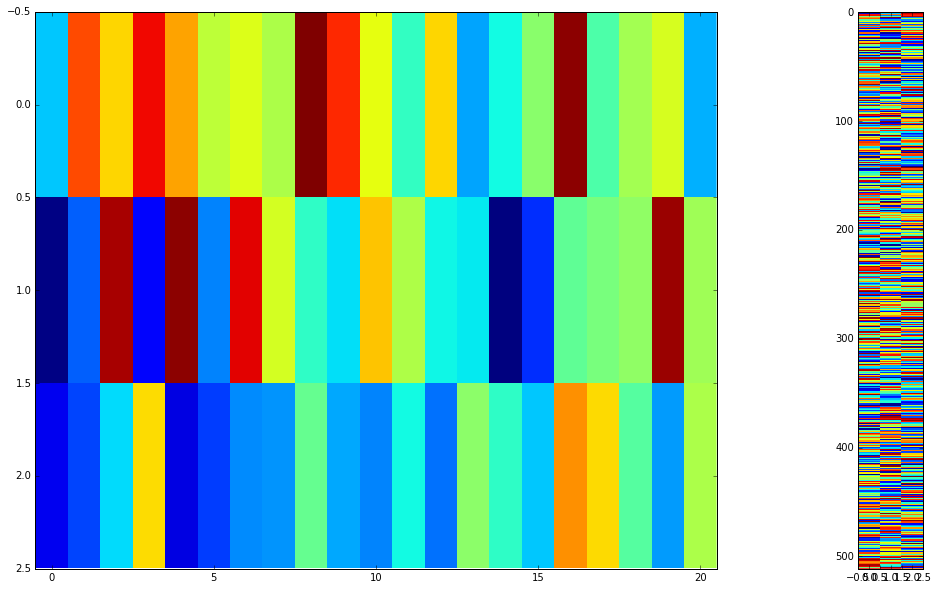

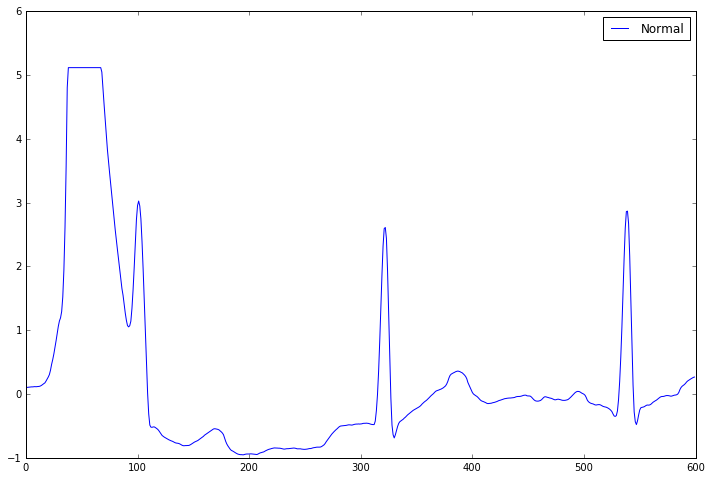

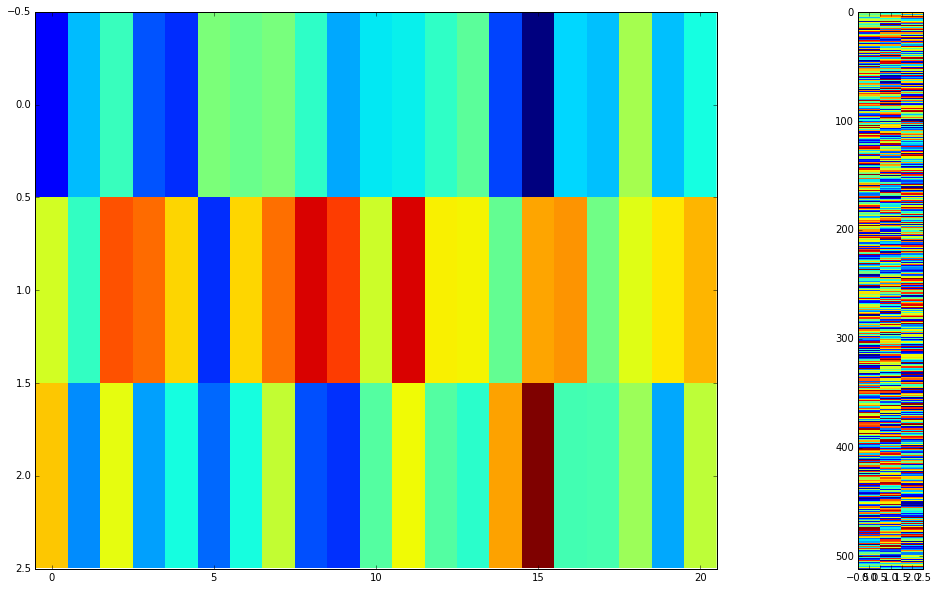

In [113]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 8]
#raw_data = next(dataiter)
test_data = Variable(-raw_data['x'].float())[None]
%time scratch_res = scratch_net.logit(scratch_net.forward_features(test_data))
%time loaded_res = loaded_net.logit(loaded_net.forward_features(test_data))
#%time scratch_res = scratch_net.forward_features(test_data)
#%time loaded_res = (loaded_net.forward_features(test_data))


plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plt.imshow(scratch_res.data.numpy()[0], interpolation='None', aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(scratch_net.logit.weight.squeeze().data.numpy().T, aspect=.05, interpolation='None')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.show()

plt.plot(test_data.cpu().data.numpy()[0, 0], label=['Normal', 'Fibrillation', 'Other'][raw_data['y']])
plt.legend()
plt.show()


plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plt.imshow(loaded_res.data.numpy()[0], interpolation='None', aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(loaded_net.logit.weight.squeeze().data.numpy().T, aspect=.05, interpolation='None')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.show()



CPU times: user 4.94 s, sys: 180 ms, total: 5.12 s
Wall time: 142 ms
CPU times: user 7.46 s, sys: 260 ms, total: 7.72 s
Wall time: 209 ms


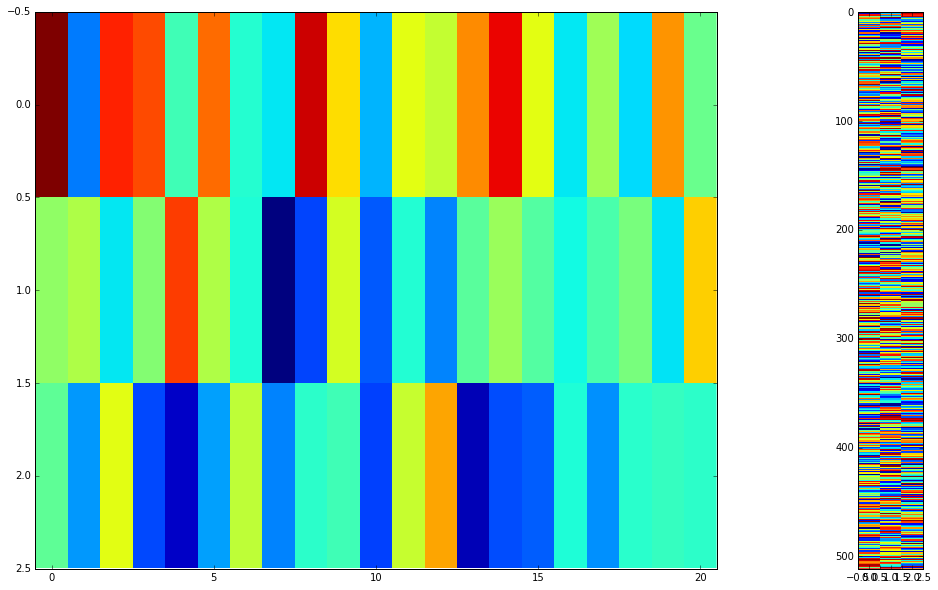

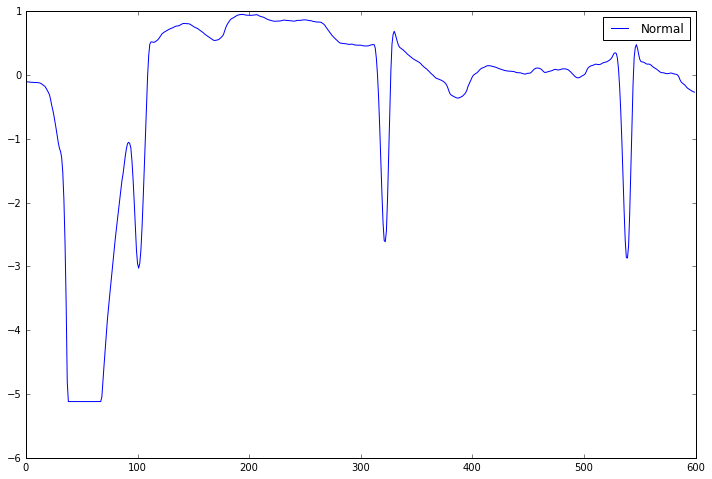

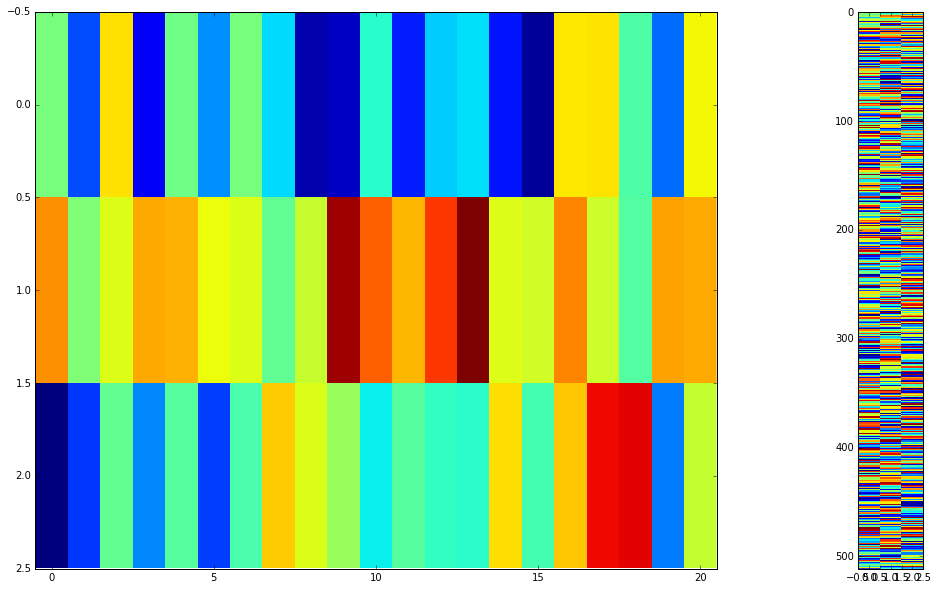

In [112]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 8]
#raw_data = next(dataiter)
test_data = Variable(raw_data['x'].float())[None]
%time scratch_res = scratch_net.logit(scratch_net.forward_features(test_data))
%time loaded_res = loaded_net.logit(loaded_net.forward_features(test_data))
#%time scratch_res = scratch_net.forward_features(test_data)
#%time loaded_res = (loaded_net.forward_features(test_data))


plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plt.imshow(scratch_res.data.numpy()[0], interpolation='None', aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(scratch_net.logit.weight.squeeze().data.numpy().T, aspect=.05, interpolation='None')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.show()

plt.plot(test_data.cpu().data.numpy()[0, 0], label=['Normal', 'Fibrillation', 'Other'][raw_data['y']])
plt.legend()
plt.show()


plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plt.imshow(loaded_res.data.numpy()[0], interpolation='None', aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(loaded_net.logit.weight.squeeze().data.numpy().T, aspect=.05, interpolation='None')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.show()



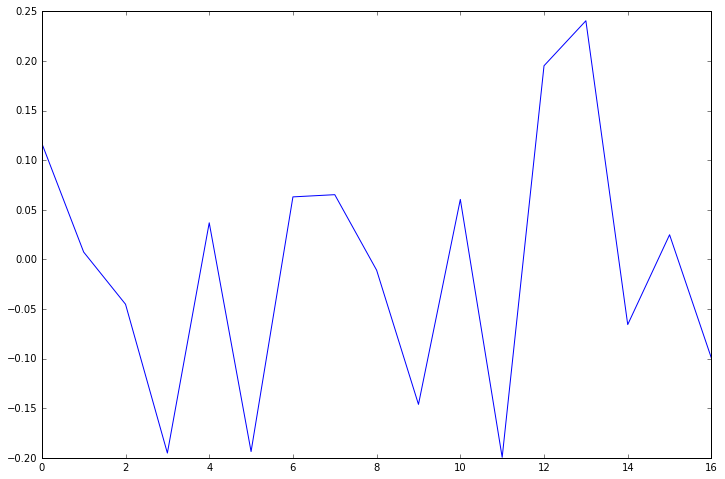

In [102]:
plt.plot(loaded_net.conv_init.weight[0].data.numpy().squeeze().T)
plt.show()

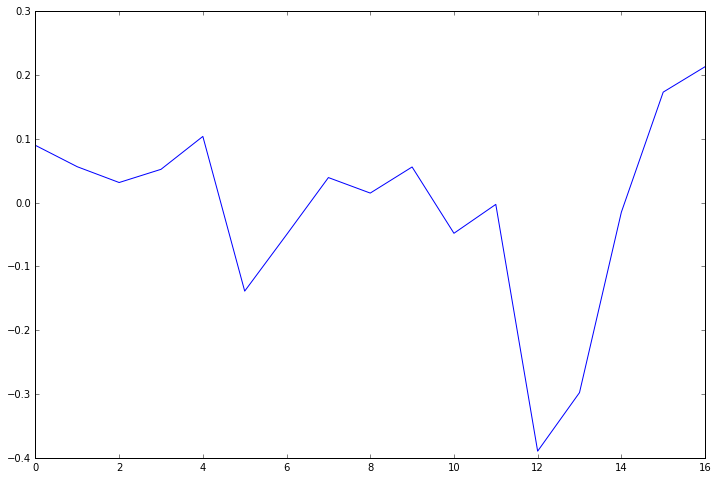

In [103]:
plt.plot(scratch_net.conv_init.weight[0].data.numpy().squeeze().T)
plt.show()

In [115]:
loaded_net.net[:3]

TypeError: unorderable types: slice() < int()

In [19]:
%%timeit
res = net.forward_features(test_data)

11.5 ms ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%%time
res = net.forward_features(test_data).cpu()

CPU times: user 17.7 ms, sys: 3.95 ms, total: 21.6 ms
Wall time: 20.9 ms
